In [42]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

In [43]:
seed = 1234
np.random.seed(seed)
random.seed(seed)

### 1 - Load dataset

In [44]:
# Read from CSV to Pandas DataFrame
url = "https://raw.githubusercontent.com/GokuMohandas/Made-With-ML/main/datasets/tumors.csv"
df = pd.read_csv(url, header=0) # load

df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()

,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [45]:
# Define X and y
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

# another way to do it
# X = df[["leukocyte_count", "blood_pressure"]].values
# y = df["tumor_class"].values

In [46]:
print(f'The shape of X: {X.shape} ')
print(f'The shape of y: {y.shape} ')

The shape of X: (1000, 2) 
The shape of y: (1000,) 


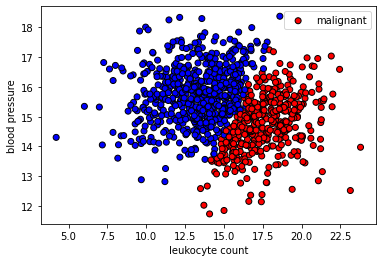

In [47]:
colors = {"benign": "red", "malignant": "blue"}

plt.scatter(X[:,0], X[:,1], c=[colors[ClassLabel] for ClassLabel in y], edgecolors="k" )
plt.xlabel('leukocyte count')
plt.ylabel('blood pressure')
plt.legend(["malignant", "benign"], loc='upper right')
plt.show()

### 2 - Split data

In [48]:
from sklearn.model_selection import train_test_split
import collections

In [49]:
TRAIN_size = 0.7
VAL_size = 0.15
TEST_size = 0.15

In [50]:
def train_val_test_split(X, y, train_size):
    """ Split dataset into data splits"""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_size, random_state=15)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_, random_state=5)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [51]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_size)

# print data shapes
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")

X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [20.59855272 14.27549124] → benign


Now let's see how many samples per class each data split has:

In [52]:
# overall class distribution
class_count = dict(collections.Counter(y))
print (f"Classes: {class_count}")

print(f"m:b = {class_count['malignant'] / class_count['benign']:.2f}")

Classes: {'benign': 389, 'malignant': 611}
m:b = 1.57


In [53]:
# per distribution
train_class_count = dict(collections.Counter(y_train))
test_class_count = dict(collections.Counter(y_test))
val_class_count = dict(collections.Counter(y_val))

print (f"train m:b = {train_class_count['malignant']/train_class_count['benign']:.2f}")
print (f"val m:b = {val_class_count['malignant']/val_class_count['benign']:.2f}")
print (f"test m:b = {test_class_count['malignant']/test_class_count['benign']:.2f}")


train m:b = 1.61
val m:b = 1.46
test m:b = 1.50


In [54]:
pd.DataFrame(y_train).value_counts()

malignant    432
benign       268
dtype: int64

In [18]:
len(y_train)

700

### 3 - Label encoding
classe labels are text, we need to encode them to integers so we can use them in our models.
we'll use `LabelEncoder` from scikit-learn.

In [55]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)


In [59]:
y_test = le.transform(y_test)
y_val = le.transform(y_val)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [66]:
# counts = pd.DataFrame(y_train).value_counts()
# calculate class weights via:
# weight_0 = 1.0/pd.DataFrame(y_train).value_counts()[0]
# weight_1 = 1.0/pd.DataFrame(y_train).value_counts()[1]


1    439
0    261
dtype: int64

We also want to calculate our class weights, which are useful for weighting the loss function during training.

In [61]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")


counts: [268 432]
weights: {0: 0.0037313432835820895, 1: 0.0023148148148148147}


### 4 - Standardize the data
we need to standardize our data (normalize scales) so if one feature is on bigger scale than the other, we guarantee it doesn't affect how the model learns its weights.
> We need to standardize our data (zero mean and unit variance) so a specific feature's magnitude doesn't affect how the model learns its weights.

In [62]:
from sklearn.preprocessing import StandardScaler

In [63]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)

In [64]:
X_train

array([[20.59855272, 14.27549124],
       [15.94887403, 17.83833301],
       [14.9977088 , 15.29272256],
       ...,
       [17.5343953 , 15.4259345 ],
       [15.06124942, 13.90980097],
       [14.75902055, 16.51108442]])

In [65]:
# Apply scaler on training and test data (don't standardize outputs for classification)

X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

Check (means should be ~0 and std should be ~1)


In [66]:
print(f"X_test[0]: mean: {np.mean(X_test[:,0]):.1f}, std: {np.std(X_test[:,0]):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")


X_test[0]: mean: 0.0, std: 1.1
X_test[1]: mean: -0.1, std: 1.1


---
skip these visualizations 

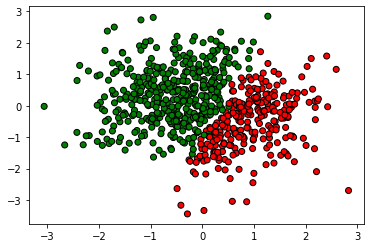

In [67]:
colors = {
    0:"red",
    1:"green"
}
# X_train.shape
plt.scatter(X_train[:,0], X_train[:,1], c = [colors[num] for num in y_train], edgecolors='k' )
plt.show()

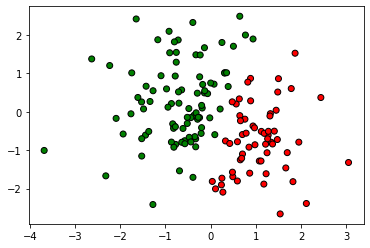

In [69]:
# X_train.shape
colors = {
    0:"red",
    1:"green"
}

plt.scatter(X_test[:,0], X_test[:,1], c = [colors[num] for num in y_test], edgecolors='k' )
plt.show()

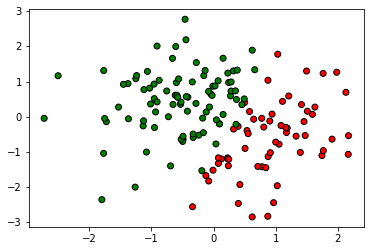

In [70]:
# X_train.shape
colors = {
    0:"red",
    1:"green"
}

plt.scatter(X_val[:,0], X_val[:,1], c = [colors[num] for num in y_val], edgecolors='k' )
plt.show()


skip these visualizations 


---

**Initialize weights**


In [72]:
INPUT_DIM = X_train.shape[1] # X is 2-dimensional
NUM_CLASSES = len(le.classes_) # y has two possibilities (begign or malignant)


# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))
print (f"W: {W.shape}")
print (f"b: {b.shape}")


W: (2, 2)
b: (1, 2)


**Model**

In [73]:
# Forward pass [NX2] · [2X2] + [1,2] = [NX2]
logits = np.dot(X_train, W) + b
print (f"logits: {logits.shape}")
print (f"sample: {logits[0]}")

logits: (700, 2)
sample: [0.00669799 0.00527116]


In [74]:
# Normalization via softmax to obtain class probabilities
exp_logits = np.exp(logits)
y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
print (f"y_hat: {y_hat.shape}")
print (f"sample: {y_hat[0]}")


y_hat: (700, 2)
sample: [0.50035671 0.49964329]


**Loss**

In [75]:
# Loss
correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
loss = np.sum(correct_class_logprobs) / len(y_train)
print (f"loss: {loss:.2f}")


loss: 0.69


**Gradients**

In [76]:
# Backpropagation
dscores = y_hat
dscores[range(len(y_hat)), y_train] -= 1
dscores /= len(y_train)
dW = np.dot(X_train.T, dscores)
db = np.sum(dscores, axis=0, keepdims=True)


**Update weights**

In [77]:
LEARNING_RATE = 1e-1

# Update weights
W += -LEARNING_RATE * dW
b += -LEARNING_RATE * db


**Training**

In [78]:
NUM_EPOCHS = 50

# Initialize random weights
W = 0.01 * np.random.randn(INPUT_DIM, NUM_CLASSES)
b = np.zeros((1, NUM_CLASSES))


In [79]:
# Training loop
for epoch_num in range(NUM_EPOCHS):

    # Forward pass [NX2] · [2X2] = [NX2]
    logits = np.dot(X_train, W) + b

    # Normalization via softmax to obtain class probabilities
    exp_logits = np.exp(logits)
    y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    # Loss
    correct_class_logprobs = -np.log(y_hat[range(len(y_hat)), y_train])
    loss = np.sum(correct_class_logprobs) / len(y_train)

    # show progress
    if epoch_num%10 == 0:
        # Accuracy
        y_pred = np.argmax(logits, axis=1)
        accuracy =  np.mean(np.equal(y_train, y_pred))
        print (f"Epoch: {epoch_num}, loss: {loss:.3f}, accuracy: {accuracy:.3f}")

    # Backpropagation
    dscores = y_hat
    dscores[range(len(y_hat)), y_train] -= 1
    dscores /= len(y_train)
    dW = np.dot(X_train.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)

    # Update weights
    W += -LEARNING_RATE * dW
    b += -LEARNING_RATE * db


Epoch: 0, loss: 0.696, accuracy: 0.309
Epoch: 10, loss: 0.456, accuracy: 0.973
Epoch: 20, loss: 0.357, accuracy: 0.976
Epoch: 30, loss: 0.303, accuracy: 0.976
Epoch: 40, loss: 0.269, accuracy: 0.976


**Evaluation**

In [80]:
class LogisticRegressionFromScratch():
    def predict(self, x):
        logits = np.dot(x, W) + b
        exp_logits = np.exp(logits)
        y_hat = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return y_hat


In [81]:
# Evaluation
model = LogisticRegressionFromScratch()
logits_train = model.predict(X_train)
pred_train = np.argmax(logits_train, axis=1)
logits_test = model.predict(X_test)
pred_test = np.argmax(logits_test, axis=1)


In [82]:
# Training and test accuracy
train_acc =  np.mean(np.equal(y_train, pred_train))
test_acc = np.mean(np.equal(y_test, pred_test))
print (f"train acc: {train_acc:.2f}, test acc: {test_acc:.2f}")


train acc: 0.98, test acc: 0.98


In [83]:
def plot_multiclass_decision_boundary(model, X, y, savefig_fp=None):
    """Plot the multiclass decision boundary for a model that accepts 2D inputs.
    Credit: https://cs231n.github.io/neural-networks-case-study/

    Arguments:
        model {function} -- trained model with function model.predict(x_in).
        X {numpy.ndarray} -- 2D inputs with shape (N, 2).
        y {numpy.ndarray} -- 1D outputs with shape (N,).
    """
    # Axis boundaries
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Create predictions
    x_in = np.c_[xx.ravel(), yy.ravel()]
    y_pred = model.predict(x_in)
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)

    # Plot decision boundary
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot
    if savefig_fp:
        plt.savefig(savefig_fp, format="png")


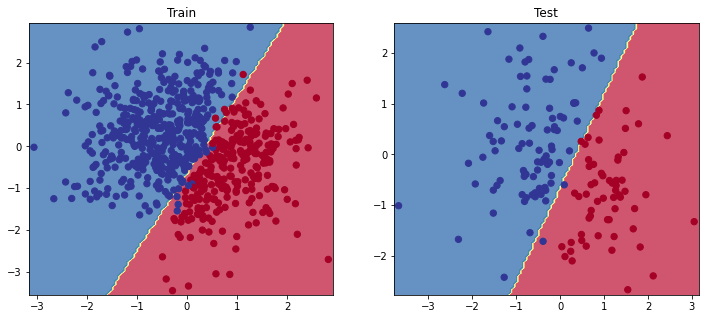

In [84]:
colors = {"benign": "red", "malignant": "blue"}


# plt.scatter(X[:,0], X[:,1], c=[colors[ClassLabel] for ClassLabel in y], edgecolors="k" )
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()


---